In [1]:
import yaml
import numpy as np
import matplotlib.pyplot as plt

## Pull dataset names and yaml file name from the yaml descibes repository

In [2]:
yamlDir = "."
yaml_file = yamlDir + "/submission.yaml"
yaml_entries = []  # List to store parsed documents

with open(yaml_file, "r") as stream:
    try:
        yaml_entries = list(yaml.safe_load_all(stream))  # Load all YAML documents
    except yaml.YAMLError as exc:
        print(exc)

# Example: Accessing name and data_file from each entry
file_list = []
list_name = []
for entry in yaml_entries:
    file_list.append(entry.get('data_file'))
    list_name.append(entry.get('name'))
    
    print(f"Name: {entry.get('name')}, Data File: {entry.get('data_file')}")

Name: None, Data File: None
Name: Total Reconstructed Visible Energy, Data File: dark_portal_reconstructedenergy.yaml
Name: Reconstructed Primary Shower Energy w.r.t Neutrino Beam, Data File: dark_portal_reconstructedangle.yaml
Name: NC $\pi^{0}$ Rejection BDT score, Data File: dark_portal_ncpi0rejection.yaml
Name: True $e^{+}e^{-}$ Energy Asymmetry, Data File: dark_portal_efficiency.yaml
Name: True $e^{+}e^{-}$ Opening Angle, Data File: dark_portal_angle.yaml
Name: True $e^{+}e^{-}$ Energy, Data File: dark_portal_energy.yaml
Name: True $e^{+}e^{-}$ $\theta$, Data File: dark_portal_angle2.yaml
Name: 2γ1p NC $\pi^{0}$ selections, Data File: dark_portal_2g1p.yaml
Name: 2γ0p NC $\pi^{0}$ selections, Data File: dark_portal_2g0p.yaml
Name: Covariance Matrix, Data File: covariance_matrix.yaml


#### Identify which titles are for 2D vs. 1D plots (look at your dataset in HEPdata, specific for this dataset)

In [3]:
file_list_eff = []
file_name_eff = []
file_list_cov = []
file_name_cov = []
file_list_1D = []
file_name_1D = []
for i in range(len(list_name)):
    if list_name[i] is None:
        continue
    if "Covariance" in list_name[i]:
        file_list_cov.append(file_list[i][:-5]) #remove the .yaml for ease
        file_name_cov.append(list_name[i])
    elif "True" in list_name[i]: #identify
        file_list_eff.append(file_list[i][:-5]) #remove the .yaml for ease
        file_name_eff.append(list_name[i])
    else:
        file_list_1D.append(file_list[i][:-5]) #remove the .yaml for ease
        file_name_1D.append(list_name[i])

## 1D Plots for Data and MC

In [4]:
yaml_names = file_list_1D
yaml_name_pretty = file_name_1D
yaml_dict = {}
for yaml_file in yaml_names:
    print(yaml_file)
    with open(yamlDir + "/" + yaml_file + ".yaml", "r") as stream:
        try:
            yaml_dict[yaml_file] = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)
yaml_dict_1D = yaml_dict

dark_portal_reconstructedenergy
dark_portal_reconstructedangle
dark_portal_ncpi0rejection
dark_portal_2g1p
dark_portal_2g0p


In [5]:
def pull_dependent_vars(data_list_here):    
    data_series = {}
    save_names = []
    for entry in data_list_here:
        name_here = entry['header']['name']
        save_names.append(name_here)
        values = []
        errors = []

        for v in entry['values']:
            values.append(v['value'])
            if 'errors' in v and v['errors']:  # Check for presence of errors
                if 'asymerror' in v['errors'][0]:
                    err_minus = -v['errors'][0]['asymerror']['minus']
                    err_plus = v['errors'][0]['asymerror']['plus']
                else:
                    err_minus = v['errors'][0]['symerror']
                    err_plus = v['errors'][0]['symerror']
            else:
                err_minus, err_plus = 0, 0  # Default to no error if missing

            errors.append([err_minus, err_plus])

        data_series[name_here] = {'values': values, 'errors': np.array(errors).T}  # Transpose errors
    size = len(data_series[name_here]["values"])
    return data_series, size, save_names

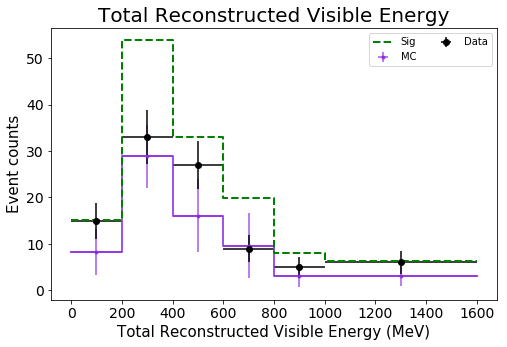

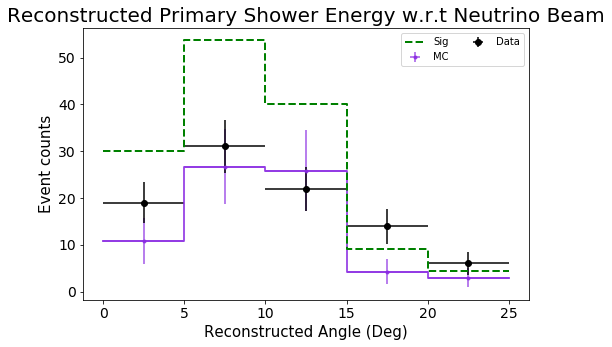

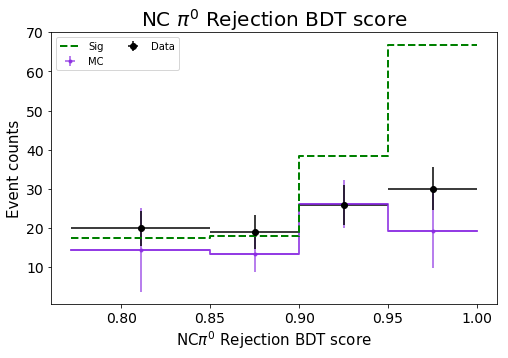

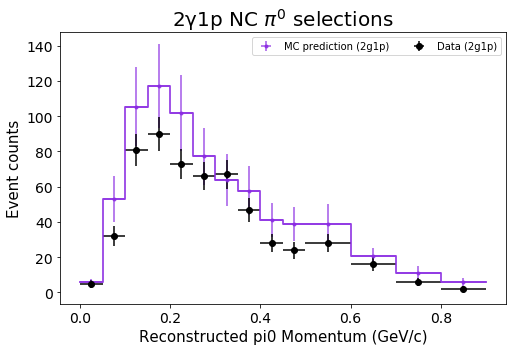

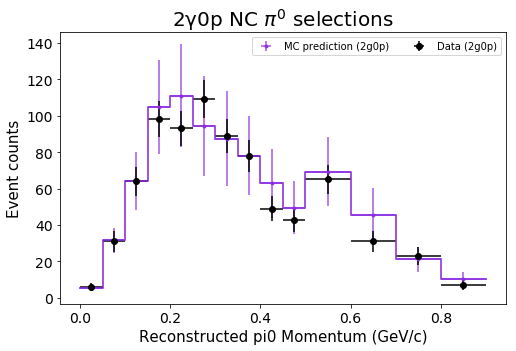

In [11]:
color_data = ["red","blue","lightblue","pink"]
color_other = ["blueviolet","seagreen","orange","cyan","brown","gray","magenta"]

for i in range(len(yaml_names)):
    
    #### PULL 1D DATASET X-AXIS #######   
    #Check for 1D, only 1 indepedent variable
    i_vars = 0 #index for single independent variable
    assert len(yaml_dict[yaml_names[i]]["independent_variables"]) == 1, "Plotting 1D only"
    indep_var = yaml_dict[yaml_names[i]]["independent_variables"][i_vars]
        
    center = []
    bin_low = []
    bin_high = []
    xerrors = []
    for v in indep_var['values']:
        center.append((v['low']+v['high'])/2)
        bin_low.append(v['low'])
        bin_high.append(v['high'])
        xerrors.append((v['high']-v['low'])/2.)
    x_values = center
    bin_size = np.array(bin_high) - np.array(bin_low)
    bin_low.append(bin_high[-1]) #for step histogram, need final step line plotted

    #### PULL DATASET COLUMNS  ###############
    data_list = yaml_dict[yaml_names[i]]["dependent_variables"]
    data_series, size, names_here = pull_dependent_vars(data_list)
    
    ### PLOT DATASETS INSIDE SAME FIGURE ####
    plt.figure(figsize=(8, 5))
    co = 0
    cd = 0
    list_size = size #Extra entry to finish the step plot line in final bin
    stacked_values = np.zeros(list_size)
    save_sig_end = None
    for name, series in data_series.items():
        y_values = series['values']
        y_errors = np.array(series['errors'])  # Transpose to match errorbar forma
        #print(len(x_values),len(y_values),len(y_errors))

        if "Data" in name: #Data in black marker points with error bars
            y_errors = np.sqrt(y_values) # Add statistical error
            plt.errorbar(x_values, y_values, yerr=y_errors, xerr=xerrors, fmt='o',
                         label=name,color="k")
        elif "MC" in name: #Prediction in connected marker points with error bars
            stacked_values += y_values
            plt.errorbar(x_values, y_values, yerr=y_errors, xerr=xerrors, fmt=".",
                         label=name,color=color_other[cd],alpha=0.8)
            plt.step(bin_low, y_values + [y_values[-1]], where='post', 
                     color=color_other[cd],linewidth=2, linestyle="-",alpha=0.8)
            cd+=1
        elif name == "Sig": #Signal should be additional on top of all MC, save to plot at end
            save_sig_end = y_values
            
        else:
            print("DONT RECOGNIZE THIS NAME")

    if save_sig_end is not None: #If it found a signal column, plot on top of MC stack
        sum_here = stacked_values + save_sig_end
        y_values = np.append(sum_here,sum_here[-1])
        plt.step(bin_low, y_values, where='post', label=name,
                     linewidth=2, linestyle="--",color="green")

    # Format plot
    plt.title(yaml_name_pretty[i],fontsize=20)
    try:
        units = yaml_dict[yaml_names[i]]["independent_variables"][i_vars]["header"]["units"]
    except:
        units = None
    if units is not None:
        plt.xlabel(yaml_dict[yaml_names[i]]["independent_variables"][i_vars]["header"]["name"] 
               + " (" + units + ")",fontsize=15)
    else:
        plt.xlabel(yaml_dict[yaml_names[i]]["independent_variables"][i_vars]["header"]["name"],
                    fontsize=15)
    plt.ylabel("Event counts",fontsize=15)
    plt.xticks(fontsize=14)  # Bigger x-axis ticks
    plt.yticks(fontsize=14) 
    plt.legend(ncol=2)
    plt.savefig(yamlDir + "/plot_" + yaml_names[i] + ".png")

## 1D Efficiency

In [8]:
yaml_names = file_list_eff
yaml_name_pretty = file_name_eff
yaml_dict = {}
for yaml_file in yaml_names:
    print(yaml_file)
    with open(yamlDir + "/" + yaml_file + ".yaml", "r") as stream:
        try:
            yaml_dict[yaml_file] = yaml.safe_load(stream)  # Load all YAML documents
        except yaml.YAMLError as exc:
            print(exc)

dark_portal_efficiency
dark_portal_angle
dark_portal_energy
dark_portal_angle2


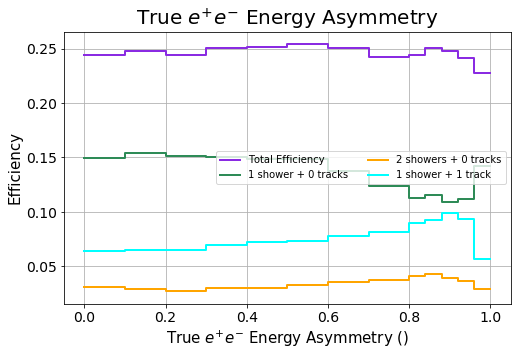

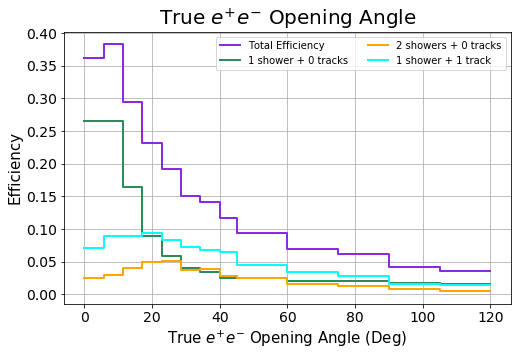

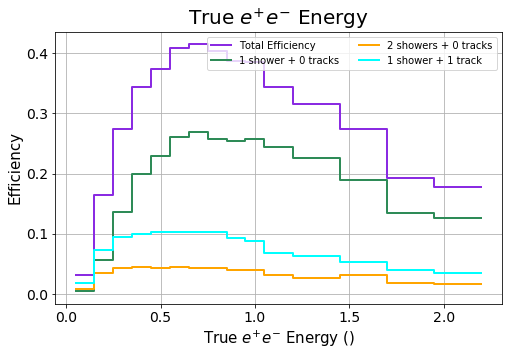

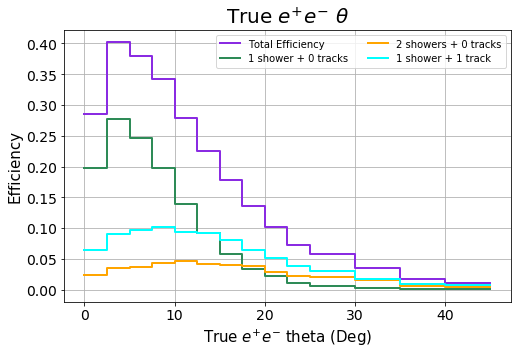

In [21]:
color_data = ["red","blue","lightblue","pink"]
color_other = ["blueviolet","seagreen","orange","cyan","brown","gray","magenta"]

for i in range(len(yaml_names)):
    
    #### PULL 1D DATASET X-AXIS #######   
    #Check for 1D, only 1 indepedent variable
    i_vars = 0 #index for single independent variable
    assert len(yaml_dict[yaml_names[i]]["independent_variables"]) == 1, "Plotting 1D only"
    assert len(yaml_dict[yaml_names[i]]["independent_variables"][0]['values'][0]), "Expecting high/low bin in 1st column"
    indep_var = yaml_dict[yaml_names[i]]["independent_variables"][i_vars]
        
    center = []
    bin_low = []
    bin_high = []
    xerrors = []
    for v in indep_var['values']:
        center.append((v['low']+v['high'])/2.)
        bin_low.append(v['low'])
        bin_high.append(v['high'])
        xerrors.append((v['high']-v['low'])/2.)
    x_values = center
    bin_low.append(bin_high[-1]) #for step histogram, need final step line plotted
    
    #### PULL DATASET COLUMNS  ###############
    data_list = yaml_dict[yaml_names[i]]["dependent_variables"]

    # Extract y-values and errors
    data_series = {}
    for entry in data_list:
        name = entry['header']['name']
        #print(name)
        values = []
        errors = []

        for v in entry['values']:
            values.append(v['value'])
            if 'errors' in v and v['errors']:  # Check for presence of errors
                if 'asymerror' in v['errors'][0]:
                    err_minus = -v['errors'][0]['asymerror']['minus']
                    err_plus = v['errors'][0]['asymerror']['plus']
                else:
                    err_minus = v['errors'][0]['symerror']/2.
                    err_plus = v['errors'][0]['symerror']/2.
            else:
                err_minus, err_plus = 0, 0  # Default to no error if missing

            errors.append([err_minus, err_plus])

        data_series[name] = {'values': values, 'errors': np.array(errors).T}  # Transpose errors

    ### PLOT DATASETS INSIDE SAME FIGURE ####
    ### Handles colors up to 7 MC and 4 Prediction (not counting Data and LEE model)#######
    plt.figure(figsize=(8, 5))
    co = 0
    cd = 0
    list_size = len(data_series[name]["values"]) + 1 #Extra entry to finish the step plot line in final bin
    stacked_values = np.zeros(list_size)
    save_LEE_end = None
    for name, series in data_series.items():

        y_values = series['values']
        y_errors = np.array(series['errors'])  # Transpose to match errorbar format    
        y_hist_plot = np.copy(y_values)
        y_hist_plot = np.append(y_hist_plot,y_values[-1])
        plt.errorbar(x_values, y_values, yerr = y_errors, linewidth=2, fmt = "None", color=color_other[co])
        plt.step(bin_low, y_hist_plot, where='post',
                 label=name,linewidth=2, color=color_other[co])
        co+=1
        

    # Format plot
    plt.title(yaml_name_pretty[i],fontsize=20)
    try:
        units = yaml_dict[yaml_names[i]]["independent_variables"][i_vars]["header"]["units"]
    except:
        units = None
    if units is not None:
        plt.xlabel(yaml_dict[yaml_names[i]]["independent_variables"][i_vars]["header"]["name"] 
               + " (" + units + ")",fontsize=15)
    else:
        plt.xlabel(yaml_dict[yaml_names[i]]["independent_variables"][i_vars]["header"]["name"],
                    fontsize=15)
    plt.ylabel("Efficiency",fontsize=15)
    plt.xticks(fontsize=14)  # Bigger x-axis ticks
    plt.yticks(fontsize=14)
    plt.grid()
    plt.legend(ncol=2)
    plt.savefig(yamlDir + "/plot_" + yaml_names[i] + ".png",bbox_inches='tight')

## Covariance Matrix

In [22]:
yaml_names = file_list_cov
yaml_name_pretty = file_name_cov
yaml_dict = {}
for yaml_file in yaml_names:
    print(yaml_file)
    with open(yamlDir + "/" + yaml_file + ".yaml", "r") as stream:
        try:
            yaml_dict[yaml_file] = yaml.safe_load(stream)  # Load all YAML documents
        except yaml.YAMLError as exc:
            print(exc)

covariance_matrix


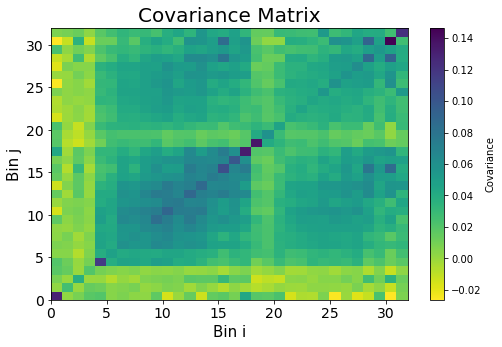

In [24]:
for i in range(len(yaml_names)):
    
    #### PULL 2D DATASET X-AXIS #######    
    #Check for 2D, 2 and only 2 indepedent variables
    assert len(yaml_dict[yaml_names[i]]["independent_variables"]) == 2, "Plotting 2D only"
    indep_var1 = yaml_dict[yaml_names[i]]["independent_variables"][0]
    indep_var2 = yaml_dict[yaml_names[i]]["independent_variables"][1]
    var1_header = yaml_dict[yaml_names[i]]["independent_variables"][0]["header"]
    var2_header = yaml_dict[yaml_names[i]]["independent_variables"][1]["header"]

    assert len(indep_var1["values"]) == len(indep_var2["values"])
    
    #### PULL DATASET COLUMNS, if more than 1, make more than 1 plot ###############
    data_list = yaml_dict[yaml_names[i]]["dependent_variables"]

    # Extract y-values per column
    data_series = {}
    for entry in data_list:
        name = entry['header']['name']
        zvar_name = name.replace(" ","")
        assert len(indep_var1["values"]) == len(entry["values"])

        z_values = []
        x_values = []
        y_values = []
        for index in range(len(entry['values'])):
            x_values.append(indep_var1["values"][index]["value"])
            y_values.append(indep_var2["values"][index]["value"])
            z_values.append(entry["values"][index]['value'])

        X = np.unique(x_values)
        Y = np.unique(y_values)
        Z = np.zeros((len(X), len(Y)))
        X_low = (X[1:] - X[:-1])/2 #bin sizes for plots
        Y_low = (Y[1:] - Y[:-1])/2
        
        # Fill Z matrix
        for xi in range(len(X)):
            for yi in range(len(Y)):
                Z[xi, yi] = z_values[xi*len(Y)+yi]
        plt.figure(figsize=(8, 5))
        X_plot = np.append(X, X[-1]+2*X_low[-1]) #pcolormesh needs len(X) + 1 to plot all of Z
        Y_plot = np.append(Y,Y[-1]+2*Y_low[-1]) #pcolormesh needs len(Y) + 1 to plot all of Z
        plt.pcolormesh(X_plot, Y_plot, Z.T, shading='auto', cmap='viridis_r')  # Transpose Z to match orientation
        
        # Format plot
        plt.title(yaml_name_pretty[i],fontsize=20)
        plt.colorbar(label=name)
        plt.xlabel(var1_header["name"],fontsize=15)
        plt.ylabel(var2_header["name"],fontsize=15)
        plt.xticks(fontsize=14)  # Bigger x-axis ticks
        plt.yticks(fontsize=14) 
        plt.savefig(yamlDir + "/plot_" + yaml_names[i] + "_" + zvar_name + ".png")

## Calculate Pearson Chi^2 while Matching Covariance to 1D plots

In [27]:
#Pull 1D data and prediction values and concatenate
combine_list = ["dark_portal_ncpi0rejection", "dark_portal_2g1p","dark_portal_2g0p"]
full_data = None

for file_1D in combine_list:
    data_list_1D = yaml_dict_1D[file_1D]["dependent_variables"] #signal
    data_series_values, size, save_names = pull_dependent_vars(data_list_1D)
    sig_name = None
    for name_here in save_names:
        if "Data" in name_here:
            data_name = name_here
        elif "MC" in name_here:
            mc_name = name_here
        elif "Sig" in name_here:
            sig_name = name_here
        else:
           print("I DONT KNOW NAME")
    if sig_name is not None:
        file_data = np.array(data_series_values[data_name]["values"])
        file_pred = np.array(data_series_values[mc_name]["values"]) \
                    + np.array(data_series_values[sig_name]["values"])
    else:
        file_data = np.array(data_series_values[data_name]["values"])
        file_pred = np.array(data_series_values[mc_name]["values"])
    if full_data is None:
        full_data = file_data
        full_pred = file_pred
    else:
        full_data = np.concatenate((full_data, file_data))
        full_pred = np.concatenate((full_pred,file_pred))
    if file_1D == "pandora_1g1p_energy": #Need to add empty overlay bin
        full_data = np.concatenate((full_data,np.array([0]))) #Need to add empty overflow bin
        full_pred = np.concatenate((full_pred,np.array([0]))) #Need to add empty overflow bin
                                   
# Pull convariance Matrix, with only 1 depdentdent variable
covariance_name = "covariance_matrix"
data_list = yaml_dict[covariance_name]["dependent_variables"]

assert len(yaml_dict[covariance_name]["independent_variables"]) == 2, "Plotting 2D only"
indep_var1 = yaml_dict[covariance_name]["independent_variables"][0]
indep_var2 = yaml_dict[covariance_name]["independent_variables"][1]
var1_header = yaml_dict[covariance_name]["independent_variables"][0]["header"]
var2_header = yaml_dict[covariance_name]["independent_variables"][1]["header"]


for entry in data_list:    
    name = entry['header']['name']
    zvar_name = name.replace(" ","")
    assert len(indep_var1["values"]) == len(entry["values"])

    z_values = []
    x_values = []
    y_values = []
    for index in range(len(entry['values'])):
        x_values.append(indep_var1["values"][index]["value"])
        y_values.append(indep_var2["values"][index]["value"])
        z_values.append(entry["values"][index]['value'])

    X = np.unique(x_values)
    Y = np.unique(y_values)
    Z = np.zeros((len(X), len(Y)))


    # Fill Z matrix to make covariance matrix, same as above
    for xi in range(len(X)):
        for yi in range(len(Y)):
            Z[xi, yi] = z_values[xi*len(Y)+yi]
    cov_matrix = np.array(Z)
    
    stat_cov = np.diag(full_pred)
    
    #Adjust if low stats, using Pearson Chi^2 method
    mu_cut_off = np.array([0, 0.461, 0.916, 1.382, 1.833, 2.298, 2.767, 3.225, 3.669, 4.141, 4.599])
    for lsd in range(len(full_data)):
        data_as_int = int(np.ceil(full_data[lsd]))
        if data_as_int>=1 and data_as_int<=10:
            if full_pred[lsd] < mu_cut_off[data_as_int]:
                num = (full_pred[lsd]-full_data[lsd])**2
                den = 2 * (full_pred[lsd] - full_data[lsd] + full_data[lsd] * np.log(full_data[lsd] / full_pred[lsd]))
                if (full_pred[lsd] == full_data[lsd]) and (full_pred[lsd] == 0):
                    new_diag = 1e-6
                else:
                    new_diag = num / den
                stat_cov[lsd][lsd] = new_diag

        else:
            continue
    total_cov = cov_matrix + stat_cov
    dof = len(full_data)
    
    chi2 = np.linalg.multi_dot(
            [np.transpose(full_data - full_pred),
             np.linalg.inv(total_cov), 
             full_data - full_pred])
    print(covariance_name, chi2, dof)

covariance_matrix 90.5990751084118 32
